## Recognize Text from Unstructured Scene
- [original discussion](http://www.mathworks.com/help/vision/examples/automatically-detect-and-recognize-text-in-natural-images.html)
- Approach
    - Use [MSER](http://stackoverflow.com/questions/17647500/exact-meaning-of-the-parameters-given-to-initialize-mser-in-opencv-2-4-x) to detect potential regions containing text
    - process and merge the region, make it in appropriate size
    - use OCR (tesseract) to recognize the text
- [mser example in opencv 3.0](https://github.com/Itseez/opencv/blob/master/samples/python2/mser.py)

In [1]:
%matplotlib inline

In [51]:
import matplotlib.pyplot as plt
from skimage import io, exposure, measure, morphology, color, util, filters, draw
import cv2
import numpy as np
from shapely import geometry
import networkx
import pytesseract

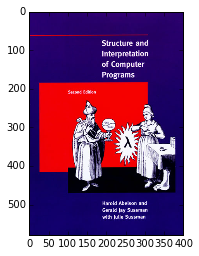

In [3]:
## load image -- cover of my favoriate computer science book
## the image is even more challenging because we have different text sizes and locations
#img = io.imread("http://www.mathworks.com/help/releases/R2015b/examples/vision_product/TextDetectionExample_01.png")
img = io.imread("https://mitpress.mit.edu/sicp/full-text/book/cover.jpg")
plt.imshow(img)
gray = color.rgb2grey(img)
#plt.figure()
#plt.imshow(gray, cmap = plt.cm.gray)

/usr/local/lib/python2.7/dist-packages/scikit_image-0.12dev-py2.7-linux-x86_64.egg/skimage/util/dtype.py:111: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


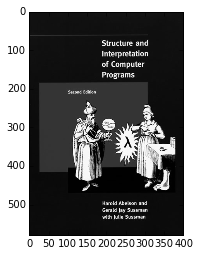

In [4]:
## opencv mser detection works on gray scale image
## util.img_as_ubyte will convert skimage images (float) to cv images(ubyte)
## or you can load the image directly by opencv
#cvimg = cv2.imread("data/sign.jpg", cv2.IMREAD_GRAYSCALE)
cvgray = util.img_as_ubyte(gray)
plt.imshow(cvgray, cmap = plt.cm.gray)

***MSER only works with gray images***

In [5]:
## use mser to detect regions of interest
mser = cv2.MSER_create()
## list of arrays of points
mser_regions = mser.detectRegions(cvgray, None)

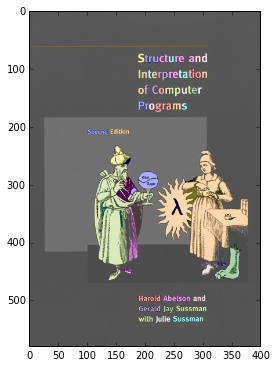

In [6]:
## show the found regions
labels = np.ones_like(cvgray) * -1
for i, pts in enumerate(mser_regions, 1):
    labels[pts[:, 1], pts[:, 0]] = i
    
plt.figure(figsize = (6, 6))
plt.imshow(color.label2rgb(labels, img, alpha = .3, bg_color = (1, 1, 1)))

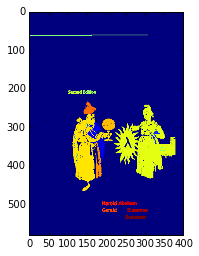

In [7]:
## filter the regions with potential text contents, suggested by the original discussion
## using features include
## Aspect Ratio: ncols / nrows
## Eccentricity: ratio of the focal distance / major axis length
## Euler Number: number of objects - number of holes
## Extent: area / nrows*ncols
## Solidity: area / convext_hull_area
regions = measure.regionprops(labels)
def is_text_region(region):
    bbox = region.bbox
    nrows = bbox[2] - bbox[0]
    ncols = bbox[3] - bbox[1]
    aspect_ratio = ncols * 1. / nrows
    return (aspect_ratio > 3
           or region.eccentricity > .99
           or region.solidity < .3
           or region.extent < .2 or region.extent > .9
           or region.euler_number < -4) 

selected_regions = filter(is_text_region, regions)
relabeled = np.ones_like(labels) * -1
for i, r in enumerate(selected_regions, 1):
    relabeled[labels==r.label] = i
    

plt.imshow(relabeled)

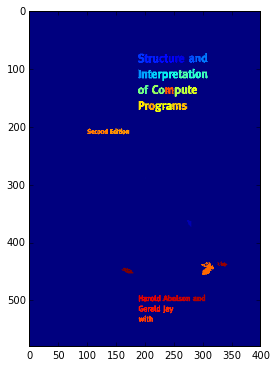

In [8]:
## the suggested RULES from the orginal article doesn't work well, as expected, 
## because the image has changed, and it shows the rule-based filtering system
## is very image dependent
regions = measure.regionprops(labels)
def is_text_region(region):
    bbox = region.bbox
    nrows = bbox[2] - bbox[0]
    ncols = bbox[3] - bbox[1]
    aspect_ratio = ncols * 1. / nrows
    angel = region.orientation * 180 / np.pi
    return (region.area < 350) and region.extent > .5 

selected_regions = filter(is_text_region, regions)
relabeled = np.ones_like(labels) * -1
for i, r in enumerate(selected_regions, 1):
    relabeled[labels==r.label] = i
    
plt.figure(figsize = (6, 6))
plt.imshow(relabeled)

In [9]:
## next step is to merge related regions into big regions that can be used with OCR
## First, extend the bbox of each region, so neighboring boxes are overlapped

def extend_box(bbox):
    minr, minc, maxr, maxc = bbox
    factor = .02
    minr, minc = (1-factor) * minr, (1-factor) * minc
    maxr, maxc = (1+factor) * maxr, (1+factor) * maxc
    ## clip
    minr, minc = max(0, minr), max(0, minc)
    maxr, maxc = min(relabeled.shape[0], maxr), min(relabeled.shape[1], maxc)
    return (minr, minc, maxr, maxc)

regions = measure.regionprops(relabeled)
extend_bboxs = [extend_box(region.bbox) for region in regions]

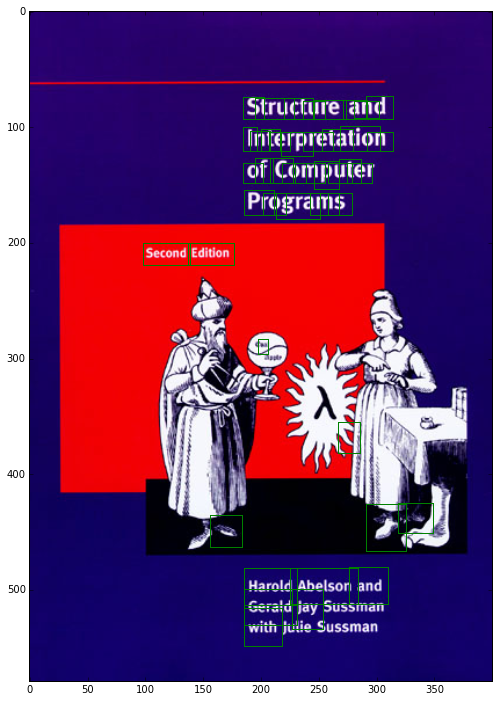

In [10]:
from matplotlib import patches
fig, ax = plt.subplots(1, 1, figsize = (12, 12))
ax.imshow(img)
ax.autoscale(False)
for bbox in extend_bboxs:
    minr, minc, maxr, maxc = bbox
    ax.add_patch(patches.Rectangle(xy = (minc, minr), width=maxc-minc, height=maxr-minr, fill=False, color = "green"))

In [20]:
## now it is time to merge overlapped regions into a big one
## the original disucssion article from mathworks discussed 
## build a graph of regions and find the connectedComponents 
g = networkx.Graph()
for i in xrange(len(extend_bboxs)-1):
    for j in xrange(i+1, len(extend_bboxs)):
        ri, rj = extend_bboxs[i], extend_bboxs[j]
        boxi = geometry.box(ri[1], ri[0], ri[3], ri[2])
        boxj = geometry.box(rj[1], rj[0], rj[3], rj[2])
        if boxi.intersection(boxj).area:
            g.add_edge(i, j)

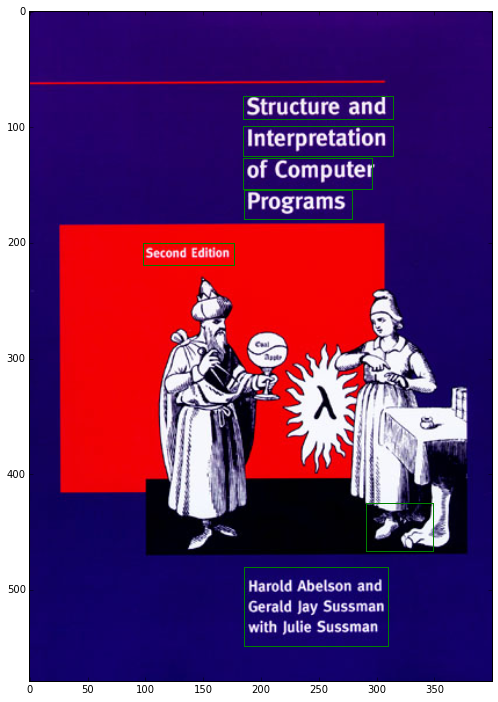

In [27]:
def get_big_bbox(boxes):
    minrs, mincs, maxrs, maxcs = zip(*boxes)
    return min(minrs), min(mincs), max(maxrs), max(maxcs)

merged_boxes = []
for iboxs in networkx.connected_components(g):
    boxes = [extend_bboxs[i] for i in iboxs]
    merged_boxes.append(get_big_bbox(boxes))
    
from matplotlib import patches
fig, ax = plt.subplots(1, 1, figsize = (12, 12))
ax.imshow(img)
ax.autoscale(False)
for bbox in merged_boxes:
    minr, minc, maxr, maxc = bbox
    ax.add_patch(patches.Rectangle(xy = (minc, minr), width=maxc-minc, height=maxr-minr, fill=False, color = "green"))

In [50]:
## and now we can detect those regions seperatly
def detect_orc(grayroi, scaling_factors = None):
    scaling_factors = np.array([1.]) if scaling_factors is None else scaling_factors
    for s in scaling_factors:
        rescaled = transform.rescale(grayroi, s)
        print "=" * 10, s
        print pytesseract.image_to_string( Image.fromarray(util.img_as_ubyte(rescaled)))
        print 
for box in merged_boxes:
    minr, minc, maxr, maxc = box
    roi = gray[minr:maxr+1, minc:maxc+1]
    detect_orc(roi, scaling_factors=[2.1])

========== 2.1
Structure and

========== 2.1
Interpretation

========== 2.1
of Computer

========== 2.1
Programs

========== 2.1
Second Edldoﬂ

========== 2.1


========== 2.1
Harold Abelson and
Gerald lay Sussman
with Julie Sussman



/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:11: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


========== 2.1
Structure and

========== 2.1
Interpretation

========== 2.1
of Computer

========== 2.1
Programs

========== 2.1
Second Edition

========== 2.1


========== 2.1


========== 2.1


========== 2.1


========== 2.1
Harold Abelson and
Gerald lay Sussman
with Julie Sussman



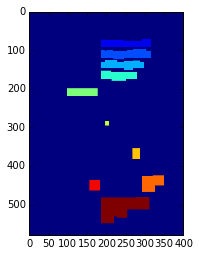

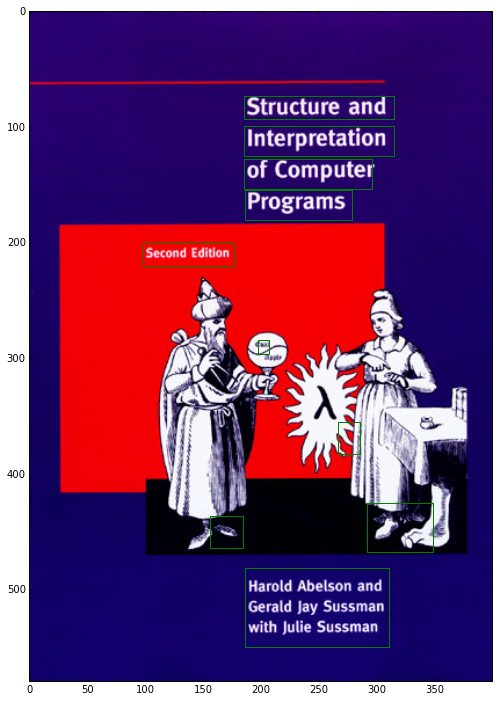

In [58]:
## another way is to make the overlapped regions bright, and do labelling to find bounding box
## EVEN BETTER ACCURACY THAN THE PREVIOUS METHOD!
mask = np.zeros_like(gray)
for box in extend_bboxs:
    minr, minc, maxr, maxc = box
    rr, cc = zip(*[(minr, minc), (maxr, minc), (maxr, maxc), (minr, maxc)])
    rs, cs = draw.polygon(rr, cc)
    mask[rs, cs] = 1

ocr_labels = measure.label(mask)
plt.imshow(ocr_labels)
merged_boxes = [r.bbox for r in measure.regionprops(ocr_labels)]

from matplotlib import patches
fig, ax = plt.subplots(1, 1, figsize = (12, 12))
ax.imshow(img)
ax.autoscale(False)
for bbox in merged_boxes:
    minr, minc, maxr, maxc = bbox
    ax.add_patch(patches.Rectangle(xy = (minc, minr), width=maxc-minc, height=maxr-minr, fill=False, color = "green"))

for box in merged_boxes:
    minr, minc, maxr, maxc = box
    roi = gray[minr:maxr+1, minc:maxc+1]
    detect_orc(roi, scaling_factors=[2.1])

In [40]:
## directly call OCR tesseract on the raw image
## NOT BAD AT ALL : )
## but one benefit of the method discussed here is that it gives both OCR and their locations
from PIL import Image
from skimage import transform

for s in np.arange(0.7, 2.1, .1):
    rescaled = transform.rescale(gray, s)
    print "=" * 10, s
    print pytesseract.image_to_string( Image.fromarray(util.img_as_ubyte(rescaled)))
    print 

========== 0.7
Slruclum and
mmpremion
nl Cnmpulel
ngvams

 

A"

 

mm Mm m
mam My 9155mm
mm Mm 5m.”

========== 0.8
5...“ mm

 

I‘-

suucmre and
Imerpremion
af Cnmvuler
Programs

mmld mm m
herald yay Sussmzn
m». Mia Susman

========== 0.9
Structure and
Interpretation
of Com punter
Programs

 

Navold Abelson and
Gerald I" Sussmin
mm mm: Sussman

========== 1.0
Structure and
Interpretation
of Computer
Programs

5mm mm

J

       

Harald Abelson and
Gerald Jay Sussman
mm Julie Sussman

========== 1.1
Structure and
Interpretation
of Computer
Programs

 

Harold Abelson and
5mm 11y Snssman
with Julie Sussmm

========== 1.2
Structure and
Interpretation
of Computer
Programs

5mm mm

   

Harold Abelson and
Guam lay Sussman
with Julie Sussman

========== 1.3
Structure and
Interpretation
of Computer
Programs

    

)g

Narold Abelson and
Gerald lay Sussman
with Julie Sussman

========== 1.4
Structure and
Interpretation
of Computer
Programs

Second term

 

Harold Abetson and
Gerald lay Suss